##  Домашнее задание № 5: Пироги с глазами!

Задание присылать на обе почты почты aleksartamonov@gmail.com dashkov.alexander.om@gmail.com в виде ссылки на colab

В теме письма указать **CV_HSE_2021 HW5 <Фамилия Имя>**

soft deadline: 02.06.2021T23:59:00+0300

hard deadline: 09.06.2021T23:59:00+0300

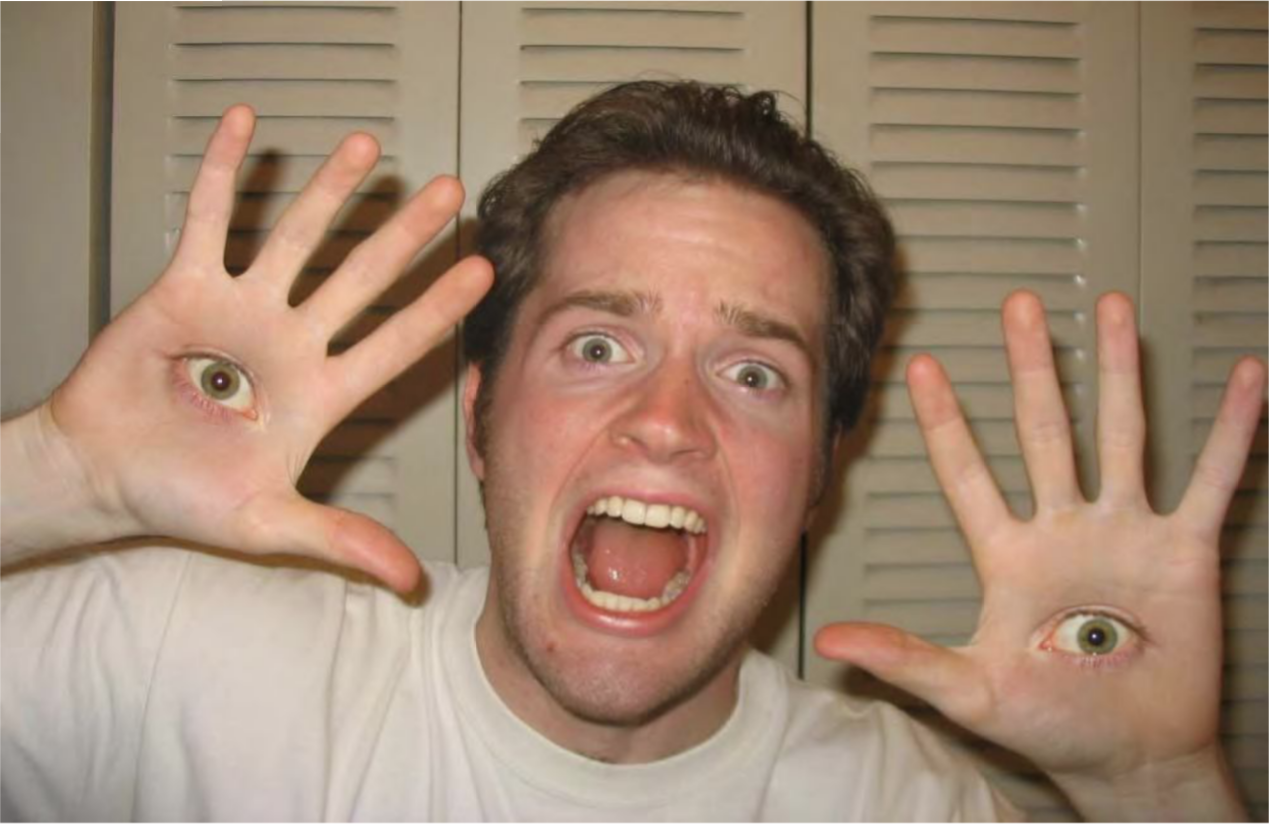

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow

### Пирамида лапласа
**(15 баллов)** Используя прием сшивки изображений с помощью пирамиды Лапласа, повторите прием с вашими глазами и вашими руками (или сделайте что-то похожее по смыслу)

In [ ]:
def get_coord(center, hw):

    x, y = center
    h, w = hw

    x_shifted = x - w 
    y_shifted = y - h

    h *= 2
    w *= 2
    hw_shifted = (h, w)

    center_shifted = (x_shifted, y_shifted)

    return center_shifted, hw_shifted

In [ ]:
def get_mask(img, coords1, coords2):

    center1, wh1 = coords1
    center2, wh2 = coords2

    img1 = img.copy()

    cv2.ellipse(img1, center1, wh1, 90, 0, 360, (255,0,0), 1)
    cv2.ellipse(img1, center2, wh2, 90, 0, 360, (255,0,0), 1)

    mask1 = np.zeros_like(img1)
    cv2.ellipse(mask1, center1, wh1, 90, 0, 360, (255,255,255), -1)
    mask1 =(mask1 / 255.).astype('float32')

    mask2 = np.zeros_like(img1)
    cv2.ellipse(mask2, center2, wh2, 90, 0, 360, (255,255,255), -1)
    mask2 =(mask2 / 255.).astype('float32')

    return img1, mask1, mask2

In [ ]:
def move_mask(img, 
                  new_img, 
                  mask, 
                  center_shifted, 
                  new_center, 
                  hw_shifted, 
                  alpha = 1):

    x, y = center_shifted
    x1, y1 = new_center
    h, w = hw_shifted

    img_copy = img.copy()
    new_img_copy = new_img.copy()
    mask_copy = mask.copy()

    final = np.zeros_like(img)

    x, y = x / img_copy.shape[1], y / img_copy.shape[0]

    h_new = int(img_copy.shape[0] * alpha)
    w_new = int(img_copy.shape[1] * alpha)

    img_copy = cv2.resize(img_copy, (w_new, h_new))
    x_new, y_new = int(w_new * x), int(h_new * y)

    final[y1:y1+h, x1:x1+w, :] = img_copy[y_new:y_new + h, x_new:x_new + w, :]
    final_mask = np.zeros_like(mask)

    mask_copy = cv2.resize(mask_copy, (w_new, h_new))
    final_mask[y1:y1+h, x1:x1+w] = mask_copy[y_new:y_new + h, x_new:x_new + w]

    new_img_copy = new_img_copy * (1 - final_mask[:,:,np.newaxis]) + final * final_mask[:,:,np.newaxis]
    
    return final_mask, new_img_copy.astype(np.uint8)

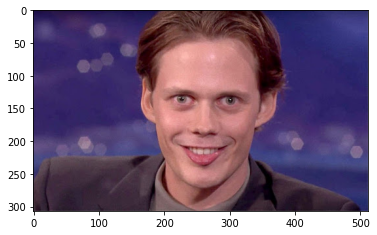

In [ ]:
img = cv2.imread('/content/111.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
center1 = (230, 135)
hw1 = (20, 35)
coords1 = (center1, hw1)
center_shifted1, hw_shifted1 = get_coord(center1, hw1)
new_center1 = (200, 70)

center2 = (300, 135)
hw2 = (20, 35)
coords2 = (center2, hw2)
center_shifted2, hw_shifted2 = get_coord(center2, hw2)
new_center2 = (270, 70)

img1, mask1, mask2 = get_mask(img, coords1, coords2)

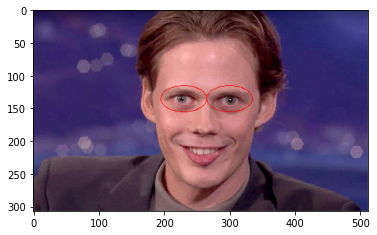

In [ ]:
plt.imshow(img1)

In [ ]:
eye1 = (mask1 * img).astype(np.uint8)
eye2 = (mask2 * img).astype(np.uint8)

new_mask1, new_img = move_mask(eye1, 
                                img, 
                                mask1[:, :, 0], 
                                center_shifted1, 
                                new_center1, 
                                hw_shifted1, 
                                alpha=0.9)

new_mask2, new_img = move_mask(eye2, 
                                new_img, 
                                mask2[:, :, 0], 
                                center_shifted2, 
                                new_center2, 
                                hw_shifted2, 
                                alpha=0.9)

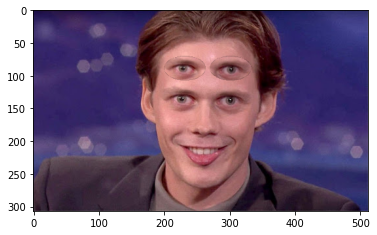

In [ ]:
plt.imshow(new_img)

In [ ]:
def gaussian_pyramid(img, num_levels):
    lower = img.copy()
    gaussian_pyr = [lower]

    for i in range(num_levels):
        lower = cv2.pyrDown(lower)
        gaussian_pyr.append(np.float32(lower))

    return gaussian_pyr

def laplacian_pyramid(gaussian_pyr):
    laplacian_top = gaussian_pyr[-1]
    num_levels = len(gaussian_pyr) - 1
    laplacian_pyr = [laplacian_top]

    for i in range(num_levels, 0, -1):
        size = (gaussian_pyr[i - 1].shape[1], gaussian_pyr[i - 1].shape[0])
        gaussian_expanded = cv2.pyrUp(gaussian_pyr[i], dstsize=size)
        laplacian = np.subtract(gaussian_pyr[i-1], gaussian_expanded)
        laplacian_pyr.append(laplacian)

    return laplacian_pyr

In [ ]:
def blend(laplacian_A, laplacian_B, mask_pyr):
    LS = []

    for la, lb, mask in zip(laplacian_A, laplacian_B, mask_pyr):
        ls = lb * mask + la * (1.0 - mask)
        LS.append(ls)

    return LS
 
def reconstruct(laplacian_pyr):
    laplacian_top = laplacian_pyr[0]
    laplacian_lst = [laplacian_top]
    num_levels = len(laplacian_pyr) - 1

    for i in range(num_levels):
        size = (laplacian_pyr[i + 1].shape[1], laplacian_pyr[i + 1].shape[0])
        laplacian_expanded = cv2.pyrUp(laplacian_top, dstsize=size)
        laplacian_top = cv2.add(laplacian_pyr[i + 1], laplacian_expanded)
        laplacian_lst.append(laplacian_top)

    return laplacian_lst

In [ ]:
def laplassian_blending(img1, img2, mask, num_levels=6):
    gaussian_pyr_1 = gaussian_pyramid(img1, num_levels)
    laplacian_pyr_1 = laplacian_pyramid(gaussian_pyr_1)

    gaussian_pyr_2 = gaussian_pyramid(img2, num_levels)
    laplacian_pyr_2 = laplacian_pyramid(gaussian_pyr_2)

    mask_pyr_final = gaussian_pyramid(mask, num_levels)
    mask_pyr_final.reverse()

    add_laplace = blend(laplacian_pyr_1, laplacian_pyr_2, mask_pyr_final)
    final  = reconstruct(add_laplace)
    
    return final[num_levels].astype(np.uint8)

In [ ]:
img1 = img.copy()
img2 = new_img.copy()

mask_ = new_mask1 + new_mask2
mask = cv2.merge([mask_, mask_, mask_]).astype('float32')

final_img = laplassian_blending(img1, img2, mask)

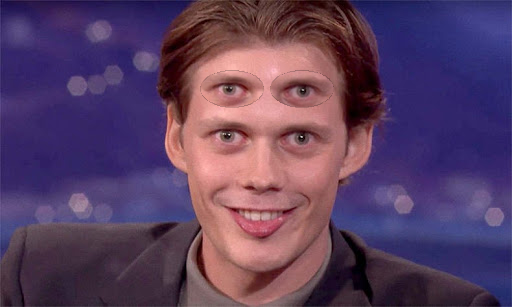

In [ ]:
cv2_imshow(cv2.cvtColor(new_img, cv2.COLOR_RGB2BGR))

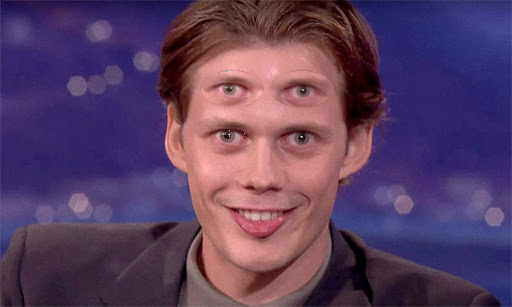

In [ ]:
cv2_imshow(cv2.cvtColor(final_img, cv2.COLOR_RGB2BGR))

### Deep Image Prior
**(15 баллов)** Используя подход [Deep Image Prior](https://github.com/DmitryUlyanov/deep-image-prior) и его способность восстанавливать изображения, повторите прием с вашими глазами и вашими руками (или сделайте что-то похожее по смыслу)

In [ ]:
#Your code here